该Notebook实现了论文 [Federated Learning with Personalization Layers](https://arxiv.org/abs/1912.00818) 中的数据异质性划分方法，并基于 FedPer 策略完成个性化联邦实验。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(["alice", "bob", "charlie"], address="local")
alice, bob, charlie = sf.PYU("alice"), sf.PYU("bob"), sf.PYU("charlie")

The version of SecretFlow: 1.9.0.dev$$DATE$$


/opt/miniconda3/envs/deepl_env/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-10-12 13:18:30,506	INFO worker.py:1724 -- Started a local Ray instance.


In [3]:
from secretflow.ml.nn.core.torch import (
    BaseModule,
    TorchModel,
    metric_wrapper,
    optim_wrapper,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

In [4]:
class SimpleCNN(BaseModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc(x)
        return x

为了实现论文中数据异质性的划分方法，依据secretflow/utils/simulation/datasets.py中加载数据集的方法写load_cifar10数据集加载方法，其中num_classes_per_client是每个客户端的随机数据集类别数，论文中取[4,8,10], 类别越少每个客户端数据集差异越明显, 每个客户端数据总量相同，如果某一类图像不够允许重复采样。

In [5]:
from typing import Dict, List, Tuple, Union
import numpy as np
from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader


def load_cifar10(
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    batch_size: int = 1,
    is_torch: bool = True,
    num_classes_per_client=4,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load CIFAR-10 dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Load CIFAR-10 training and testing sets
    trainset = CIFAR10(root="../fedper/data", train=True, download=True, transform=transform)
    testset = CIFAR10(root="../fedper/data", train=False, download=True, transform=transform)

    # Using DataLoader for Batch Processing
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Convert DataLoader to a format that SecretFlow can handle
    train_data, train_labels = _convert_to_fedndarray(
        trainloader, parts, is_torch, num_classes_per_client
    )
    test_data, test_labels = _convert_to_fedndarray(
        testloader, parts, is_torch, num_classes_per_client
    )

    return ((train_data, train_labels), (test_data, test_labels))


def create_cifar10_ndarray(
    data, labels, parts, is_torch=False, num_classes_per_client=4
):
    assert len(data) == len(labels), "Data and labels must have the same length"
    class_indices = {i: np.where(labels == i)[0] for i in range(10)}

    # Class assigned to each PYU
    pyu_classes = {}
    total_samples = len(data)
    for idx, pyu in enumerate(parts.keys()):
        np.random.seed(idx)
        pyu_classes[pyu] = np.random.choice(10, num_classes_per_client, replace=False)

    # Assign data and labels to each PYU
    pyu_data = {}
    pyu_labels = {}
    for pyu, proportion in parts.items():
        pyu_sample_size = int(
            total_samples * proportion
        )  # Calculate the sample size for each PYU
        # Sample data from selected classes for each PYU
        indices = np.concatenate(
            [
                np.random.choice(
                    class_indices[cls],
                    size=pyu_sample_size // num_classes_per_client,
                    replace=True,
                )
                for cls in pyu_classes[pyu]
            ]
        )
        np.random.shuffle(indices)
        pyu_data[pyu] = data[indices]
        pyu_labels[pyu] = labels[indices]
        # Print the amount of data and random classes for each PYU
        print(
            f"the sample size of {pyu} is {len(pyu_data[pyu])}, random classes are {pyu_classes[pyu]}."
        )
        # print(pyu_labels[pyu][0].dtype)

    # Convert data and labels to FedNdarray
    data_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    labels_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray


def _convert_to_fedndarray(dataloader, parts, is_torch, num_classes_per_client):
    data_list = []
    label_list = []
    for data, label in dataloader:
        if is_torch:
            data = data.numpy()
            label = label.numpy()
        data_list.append(data)
        label_list.append(label)

    return create_cifar10_ndarray(
        np.concatenate(data_list),
        np.concatenate(label_list),
        parts=parts,
        is_torch=is_torch,
        num_classes_per_client=num_classes_per_client,
    )

这里使用两个客户端做演示，每个客户端数据量为10%，即5000训练集和1000验证集，客户端图像类别数为4。

In [6]:
(train_data, train_label), (test_data, test_label) = load_cifar10(
    parts={alice: 0.1, bob: 0.1},
    is_torch=True,
    num_classes_per_client=4,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=SimpleCNN,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average="micro"),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average="micro"),
    ],
)

Files already downloaded and verified
Files already downloaded and verified
the sample size of alice is 5000, random classes are [2 8 4 9].
the sample size of bob is 5000, random classes are [2 9 6 4].
the sample size of alice is 1000, random classes are [2 8 4 9].
the sample size of bob is 1000, random classes are [2 9 6 4].


先打印出模型结构来确认客户端个性层数量Kp，注意Kp和模型的层数不同，模型参数列表中倒数Kp层是个性层。默认Kp为2指定的是全连接层的weight和bias，即下方打印的fc.weight和fc.bias。

In [7]:
net = SimpleCNN()
for name, param in net.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc.weight torch.Size([10, 2048])
fc.bias torch.Size([10])


要使用FedPer策略，指定strategy='fed_per'，超参数Kp指定客户端个性化层的数量。

In [8]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_afk",  # fl strategy
    # strategy='fed_avg_w',
    backend="torch",
    mu=0.5,
    lamb=0.3,
)

INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party bob.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party alice.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party bob.


模型训练，这里以16个epoch为例，选用不同策略后需要重新训练并画出结果。

In [9]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=16,
    batch_size=128,
    aggregate_freq=4,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x3a945d120>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac1360>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac74f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac7850>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 16, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac07f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac0850>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x3a9ac7430>, PYURuntim

Epoch 1/16


(ActorPYUFedAFK pid=93854) /Users/jymao/Code/PythonProjects/secretflow/secretflow/ml/nn/fl/backend/torch/strategy/fed_afk.py:116: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
(ActorPYUFedAFK pid=93854)   grad_mu += dif.view(-1).T.dot(grad.view(-1))
Train Processing: :  90%|█████████ | 36/40 [00:04<00:00,  8.81it/s]/Users/jymao/Code/PythonProjects/secretflow/secretflow/ml/nn/metrics.py:62: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/16
(ActorPYUFedAFK pid=93855) {'train-loss': 1.097813367843628, 'train_multiclassaccuracy': tensor(0.4160), 'train_multiclassprecision': tensor(0.4160), 'val_eval_multiclassaccuracy': tensor(0.3970), 'val_eval_multiclassprecision': tensor(0.3970)}


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/16
(ActorPYUFedAFK pid=93855) {'train-loss': 1.0358185768127441, 'train_multiclassaccuracy': tensor(0.4473), 'train_multiclassprecision': tensor(0.4473), 'val_eval_multiclassaccuracy': tensor(0.3930), 'val_eval_multiclassprecision': tensor(0.3930)} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9935223460197449, 'train_multiclassaccuracy': tensor(0.4570), 'train_multiclassprecision': tensor(0.4570), 'val_eval_multiclassaccuracy': tensor(0.4010), 'val_eval_multiclassprecision': tensor(0.4010)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9862169623374939, 'train_multiclassaccuracy': tensor(0.4531), 'train_multiclassprecision': tensor(0.4531), 'val_eval_multiclassaccuracy': tensor(0.4040), 'val_eval_multiclassprecision': tensor(0.4040)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9799450039863586, 'train_multiclassaccuracy': tensor(0.4629), 'train_multiclassprecision': tensor(0.4629), 'val_eval_multiclassaccuracy': tensor(0.4070), 'val_eval_multiclassprecision': tensor(0.4070)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9737431406974792, 'train_multiclassaccuracy': tensor(0.4609), 'train_multiclassprecision': tensor(0.4609), 'val_eval_multiclassaccuracy': tensor(0.4120), 'val_eval_multiclassprecision': tensor(0.4120)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9676898717880249, 'train_multiclassaccuracy': tensor(0.4707), 'train_multiclassprecision': tensor(0.4707), 'val_eval_multiclassaccuracy': tensor(0.4170), 'val_eval_multiclassprecision': tensor(0.4170)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/16


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/16
(ActorPYUFedAFK pid=93855) {'train-loss': 0.9619891047477722, 'train_multiclassaccuracy': tensor(0.4805), 'train_multiclassprecision': tensor(0.4805), 'val_eval_multiclassaccuracy': tensor(0.4300), 'val_eval_multiclassprecision': tensor(0.4300)} [repeated 4x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/16


Train Processing: :  90%|█████████ | 36/40 [00:04<00:00,  7.61it/s, {'multiclassaccuracy': 0.51464844, 'multiclassprecision': 0.51464844, 'val_multiclassaccuracy': 0.43800002, 'val_multiclassprecision': 0.43800002}]


In [9]:
print(history.keys())

NameError: name 'history' is not defined

In [11]:
fl_model.save_model("a/model_fedafk.pth",is_test=True)

In [13]:
model_test = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_afk",  # fl strategy
    # strategy='fed_avg_w',
    backend="torch",
    mu=0.5,
    lamb=0.3,
)

model_test.load_model("a/alice/model_fedafk.pth")

INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party alice.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party bob.
INFO:root:load model success


In [14]:
import torch
checkpoint = torch.load("a/alice/model_fedafk.pth")
checkpoint2 = torch.load("a/bob/model_fedafk.pth")
load_net = SimpleCNN()
load_net2 = SimpleCNN()

# Load model state dict
load_net.load_state_dict(checkpoint['model_state_dict'])
load_net2.load_state_dict(checkpoint2['model_state_dict'])

params1 = load_net.state_dict()
params2 = load_net2.state_dict()

same = True
for param1, param2 in zip(load_net.parameters(), load_net2.parameters()):
    if not torch.equal(param1, param2):
        same = False
        break

if same:
    print("两个模型的参数相同")
else:
    print("两个模型的参数不相同")

两个模型的参数不相同


FedAvg结果

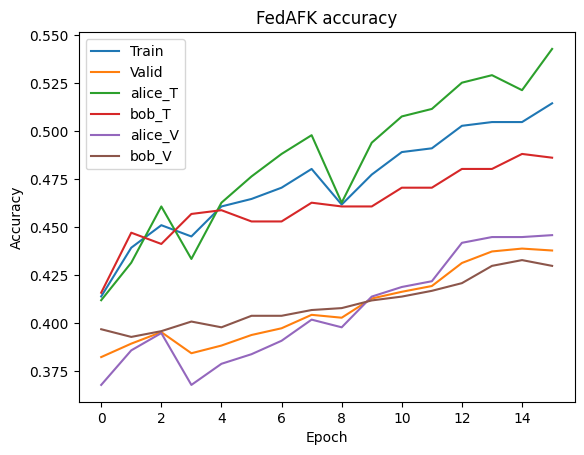

In [15]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FedAvg accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()

FedPer结果

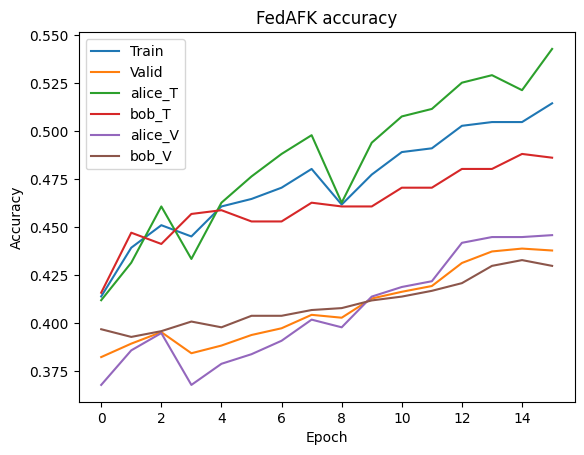

In [16]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FedAFK accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()

使用10个客户端进行100个epoch的FedPer和FedAvg对比实验

In [10]:
sf.shutdown()
sf.init(
    [
        "client1",
        "client2",
        "client3",
        "client4",
        "client5",
        "client6",
        "client7",
        "client8",
        "client9",
        "client10",
        "charlie",
    ],
    address="local",
)
(
    client1,
    client2,
    client3,
    client4,
    client5,
    client6,
    client7,
    client8,
    client9,
    client10,
    charlie,
) = (
    sf.PYU(name)
    for name in [
        "client1",
        "client2",
        "client3",
        "client4",
        "client5",
        "client6",
        "client7",
        "client8",
        "client9",
        "client10",
        "charlie",
    ]
)

(train_data, train_label), (test_data, test_label) = load_cifar10(
    parts={
        client1: 0.1,
        client2: 0.1,
        client3: 0.1,
        client4: 0.1,
        client5: 0.1,
        client6: 0.1,
        client7: 0.1,
        client8: 0.1,
        client9: 0.1,
        client10: 0.1,
    },
    is_torch=True,
    num_classes_per_client=4,
)

/opt/miniconda3/envs/deepl_env/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-10-12 13:19:58,497	INFO worker.py:1724 -- Started a local Ray instance.


Files already downloaded and verified
Files already downloaded and verified
the sample size of client1 is 5000, random classes are [2 8 4 9].
the sample size of client2 is 5000, random classes are [2 9 6 4].
the sample size of client3 is 5000, random classes are [4 1 5 0].
the sample size of client4 is 5000, random classes are [5 4 1 2].
the sample size of client5 is 5000, random classes are [3 8 4 9].
the sample size of client6 is 5000, random classes are [9 5 2 4].
the sample size of client7 is 5000, random classes are [8 1 7 0].
the sample size of client8 is 5000, random classes are [8 5 0 2].
the sample size of client9 is 5000, random classes are [8 6 9 0].
the sample size of client10 is 5000, random classes are [8 4 7 2].
the sample size of client1 is 1000, random classes are [2 8 4 9].
the sample size of client2 is 1000, random classes are [2 9 6 4].
the sample size of client3 is 1000, random classes are [4 1 5 0].
the sample size of client4 is 1000, random classes are [5 4 1 2].

先使用FedPer进行训练

In [11]:
device_list = [
    client1,
    client2,
    client3,
    client4,
    client5,
    client6,
    client7,
    client8,
    client9,
    client10,
]
server = charlie
aggregator = SecureAggregator(server, device_list)


# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_afk",  # fl strategy
    backend="torch",
    mu=0.5,
    lamb=0.3,
)

INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client1.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client2.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client3.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client4.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client5.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client6.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client7.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client8.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client9.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party client10.


(raylet) WARNING: 32 PYTHON worker processes have been started on node: 675f73c1a5ba4715ddc28c11b5e1aa1682816247f03f62e8796a52bc with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client1.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client2.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client3.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client4.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client5.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client6.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client7.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client8.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client9.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAFK'> with party client10.


In [12]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=4,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(client1): <secretflow.device.device.pyu.PYUObject object at 0x15e4e18a0>, PYURuntime(client2): <secretflow.device.device.pyu.PYUObject object at 0x15e2ec250>, PYURuntime(client3): <secretflow.device.device.pyu.PYUObject object at 0x15e4ca860>, PYURuntime(client4): <secretflow.device.device.pyu.PYUObject object at 0x3ace838e0>, PYURuntime(client5): <secretflow.device.device.pyu.PYUObject object at 0x3aced19f0>, PYURuntime(client6): <secretflow.device.device.pyu.PYUObject object at 0x3aced0d30>, PYURuntime(client7): <secretflow.device.device.pyu.PYUObject object at 0x107d46f50>, PYURuntime(client8): <secretflow.device.device.pyu.PYUObject object at 0x3acec8580>, PYURuntime(client9): <secretflow.device.device.pyu.PYUObject object at 0x3acec9a20>, PYURuntime(client10): <secretflow.device.device.pyu.PYUObject object at 0x3acec83a0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURunti

Epoch 1/20


(ActorPYUFedAFK pid=87766) /Users/jymao/Code/PythonProjects/secretflow/secretflow/ml/nn/fl/backend/torch/strategy/fed_afk.py:116: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
(ActorPYUFedAFK pid=87766)   grad_mu += dif.view(-1).T.dot(grad.view(-1))
Train Processing: :  90%|█████████ | 36/40 [00:18<00:01,  2.46it/s]/Users/jymao/Code/PythonProjects/secretflow/secretflow/ml/nn/metrics.py:62: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/20
(ActorPYUFedAFK pid=87766) {'train-loss': 1.0031191110610962, 'train_multiclassaccuracy': tensor(0.4102), 'train_multiclassprecision': tensor(0.4102), 'val_eval_multiclassaccuracy': tensor(0.3820), 'val_eval_multiclassprecision': tensor(0.3820)}


Train Processing: :  20%|██        | 8/40 [00:13<00:51,  1.62s/it](Actor_Masker pid=86999) W1012 13:21:19.341501 14595 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ActorPYUFedAFK pid=88364) /Users/jymao/Code/PythonProjects/secretflow/secretflow/ml/nn/fl/backend/torch/strategy/fed_afk.py:116: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.) [repeated 9x across cl

(ActorPYUFedAFK pid=87766) {'train-loss': 0.9730318188667297, 'train_multiclassaccuracy': tensor(0.4258), 'train_multiclassprecision': tensor(0.4258), 'val_eval_multiclassaccuracy': tensor(0.3950), 'val_eval_multiclassprecision': tensor(0.3950)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9639081954956055, 'train_multiclassaccuracy': tensor(0.4531), 'train_multiclassprecision': tensor(0.4531), 'val_eval_multiclassaccuracy': tensor(0.4060), 'val_eval_multiclassprecision': tensor(0.4060)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:34<00:03,  1.04it/s, {'multiclassaccuracy': 0.41679686, 'multiclassprecision': 0.41679686, 'val_multiclassaccuracy': 0.3787, 'val_multiclassprecision': 0.3787}]


(ActorPYUFedAFK pid=87766) {'train-loss': 0.9584200978279114, 'train_multiclassaccuracy': tensor(0.4688), 'train_multiclassprecision': tensor(0.4688), 'val_eval_multiclassaccuracy': tensor(0.4090), 'val_eval_multiclassprecision': tensor(0.4090)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/20


Train Processing: :  70%|███████   | 28/40 [00:28<00:10,  1.15it/s](ActorPYUFedAFK pid=87723) W1012 13:23:52.667927 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85057) W1012 13:23:52.867148 15619 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.954230546951294, 'train_multiclassaccuracy': tensor(0.4863), 'train_multiclassprecision': tensor(0.4863), 'val_eval_multiclassaccuracy': tensor(0.4120), 'val_eval_multiclassprecision': tensor(0.4120)} [repeated 10x across cluster]


Train Processing: :  50%|█████     | 20/40 [00:23<00:17,  1.16it/s](_run pid=85056) W1012 13:24:32.038287 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85097) W1012 13:24:32.079443 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:41<00:04,  1.16s/it, {'multiclassaccuracy': 0.43320313, 'multiclassprecision': 0.43320313, 'val_multiclassaccuracy': 0.397, 'val_multiclassprecision': 0.397}]


(ActorPYUFedAFK pid=87723) {'train-loss': 0.9562586545944214, 'train_multiclassaccuracy': tensor(0.4473), 'train_multiclassprecision': tensor(0.4473), 'val_eval_multiclassaccuracy': tensor(0.4290), 'val_eval_multiclassprecision': tensor(0.4290)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9477212429046631, 'train_multiclassaccuracy': tensor(0.4941), 'train_multiclassprecision': tensor(0.4941), 'val_eval_multiclassaccuracy': tensor(0.4180), 'val_eval_multiclassprecision': tensor(0.4180)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9450511932373047, 'train_multiclassaccuracy': tensor(0.4902), 'train_multiclassprecision': tensor(0.4902), 'val_eval_multiclassaccuracy': tensor(0.4180), 'val_eval_multiclassprecision': tensor(0.4180)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:40<00:04,  1.13s/it, {'multiclassaccuracy': 0.4441406, 'multiclassprecision': 0.4441406, 'val_multiclassaccuracy': 0.3965, 'val_multiclassprecision': 0.3965}]


(ActorPYUFedAFK pid=87766) {'train-loss': 0.9426572322845459, 'train_multiclassaccuracy': tensor(0.4941), 'train_multiclassprecision': tensor(0.4941), 'val_eval_multiclassaccuracy': tensor(0.4190), 'val_eval_multiclassprecision': tensor(0.4190)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/20


Train Processing: :   0%|          | 0/40 [00:03<?, ?it/s](_run pid=85063) W1012 13:26:54.073496 12547 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(ActorPYUFedAFK pid=87920) W1012 13:26:54.203944 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:42<00:04,  1.19s/it, {'multiclassaccuracy': 0.45878905, 'multiclassprecision': 0.45878905, 'val_multiclassaccuracy': 0.39790004, 'val_multiclassprecision': 0.39790004}]


(ActorPYUFedAFK pid=87766) {'train-loss': 0.9404754042625427, 'train_multiclassaccuracy': tensor(0.4941), 'train_multiclassprecision': tensor(0.4941), 'val_eval_multiclassaccuracy': tensor(0.4210), 'val_eval_multiclassprecision': tensor(0.4210)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/20


Train Processing: :   0%|          | 0/40 [00:03<?, ?it/s](_run pid=85062) W1012 13:27:40.083870 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85057) W1012 13:27:40.397917 12547 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:41<00:04,  1.16s/it, {'multiclassaccuracy': 0.45957032, 'multiclassprecision': 0.45957032, 'val_multiclassaccuracy': 0.3895, 'val_multiclassprecision': 0.3895}]


(ActorPYUFedAFK pid=87723) {'train-loss': 1.0163720846176147, 'train_multiclassaccuracy': tensor(0.4707), 'train_multiclassprecision': tensor(0.4707), 'val_eval_multiclassaccuracy': tensor(0.3900), 'val_eval_multiclassprecision': tensor(0.3900)} [repeated 10x across cluster]
(ActorPYUFedAFK pid=87766) 


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9365932941436768, 'train_multiclassaccuracy': tensor(0.5039), 'train_multiclassprecision': tensor(0.5039), 'val_eval_multiclassaccuracy': tensor(0.4250), 'val_eval_multiclassprecision': tensor(0.4250)} [repeated 10x across cluster]
(ActorPYUFedAFK pid=87867) 


Train Processing: :   0%|          | 0/40 [00:03<?, ?it/s](_run pid=85057) W1012 13:29:05.658053 15619 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 14x across cluster]
(_run pid=85058) W1012 13:29:16.721889 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 62x across cluster]
Train Processing: :  90%|█████████ | 36/40 [01:02<00:05,  1.42s/it](Actor_Masker pid=86812) W1012 13:30:04.026190 11779 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(ActorPYUFedAFK pid=87723) W1012 13:30:04.999305 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [01:11<00:07,  1.98s/it, {'multiclassaccuracy': 0.46855468, 'multiclassprecision': 0.46855468, 'val_multiclassaccuracy': 0.39850003, 'val_multiclassprecision': 0.

(ActorPYUFedAFK pid=87766) {'train-loss': 0.9348368644714355, 'train_multiclassaccuracy': tensor(0.5020), 'train_multiclassprecision': tensor(0.5020), 'val_eval_multiclassaccuracy': tensor(0.4220), 'val_eval_multiclassprecision': tensor(0.4220)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/20


(Actor_Masker pid=86805) W1012 13:30:13.347242 12035 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 53x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:40<00:04,  1.13s/it, {'multiclassaccuracy': 0.47285157, 'multiclassprecision': 0.47285157, 'val_multiclassaccuracy': 0.3993, 'val_multiclassprecision': 0.3993}]


(ActorPYUFedAFK pid=87766) {'train-loss': 0.9331640005111694, 'train_multiclassaccuracy': tensor(0.5000), 'train_multiclassprecision': tensor(0.5000), 'val_eval_multiclassaccuracy': tensor(0.4230), 'val_eval_multiclassprecision': tensor(0.4230)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9315488338470459, 'train_multiclassaccuracy': tensor(0.5020), 'train_multiclassprecision': tensor(0.5020), 'val_eval_multiclassaccuracy': tensor(0.4220), 'val_eval_multiclassprecision': tensor(0.4220)} [repeated 10x across cluster]


(Actor_Masker pid=86825) W1012 13:31:40.632451 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 7x across cluster]
Train Processing: :  60%|██████    | 24/40 [00:31<00:14,  1.13it/s](ActorPYUFedAFK pid=88039) W1012 13:32:07.382458 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(Actor_Masker pid=86844) W1012 13:32:08.368213 11779 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9299585223197937, 'train_multiclassaccuracy': tensor(0.5000), 'train_multiclassprecision': tensor(0.5000), 'val_eval_multiclassaccuracy': tensor(0.4280), 'val_eval_multiclassprecision': tensor(0.4280)} [repeated 10x across cluster]


(Actor_Masker pid=86850) W1012 13:32:33.776785 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 28x across cluster]
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9283868074417114, 'train_multiclassaccuracy': tensor(0.5039), 'train_multiclassprecision': tensor(0.5039), 'val_eval_multiclassaccuracy': tensor(0.4290), 'val_eval_multiclassprecision': tensor(0.4290)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:41<00:04,  1.15s/it, {'multiclassaccuracy': 0.48046875, 'multiclassprecision': 0.48046875, 'val_multiclassaccuracy': 0.40710002, 'val_multiclassprecision': 0.40710002}]


(ActorPYUFedAFK pid=87766) {'train-loss': 0.9268002510070801, 'train_multiclassaccuracy': tensor(0.5059), 'train_multiclassprecision': tensor(0.5059), 'val_eval_multiclassaccuracy': tensor(0.4260), 'val_eval_multiclassprecision': tensor(0.4260)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/20


(_run pid=85063) W1012 13:34:07.525367 12803 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 38x across cluster]
Train Processing: :  40%|████      | 16/40 [00:20<00:20,  1.14it/s](_run pid=85063) W1012 13:34:27.218019 12547 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85130) W1012 13:34:27.234235 12803 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/20
(ActorPYUFedAFK pid=87766) {'train-loss': 0.9251884818077087, 'train_multiclassaccuracy': tensor(0.5098), 'train_multiclassprecision': tensor(0.5098), 'val_eval_multiclassaccuracy': tensor(0.4280), 'val_eval_multiclassprecision': tensor(0.4280)} [repeated 10x across cluster]


Train Processing: :  80%|████████  | 32/40 [00:47<00:11,  1.42s/it](_run pid=85060) W1012 13:35:36.488152 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 26x across cluster]
(_run pid=85130) W1012 13:35:41.707506 12547 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 10x across cluster]
Train Processing: :  90%|█████████ | 36/40 [01:03<00:07,  1.76s/it, {'multiclassaccuracy': 0.48398438, 'multiclassprecision': 0.48398438, 'val_multiclassaccuracy': 0.41169995, 'val_multiclassprecision': 0.41169995}]


FedAvg训练

In [13]:
# spcify params
fl_model_avg = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_avg_w",
    backend="torch",
)
history_ = fl_model_avg.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=4,
)

INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client1.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client2.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client3.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client4.


(raylet) WARNING: 56 PYTHON worker processes have been started on node: 675f73c1a5ba4715ddc28c11b5e1aa1682816247f03f62e8796a52bc with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client5.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client6.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client7.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client8.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client9.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedAvgW'> with party client10.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(client1): <secretflow.device.device.pyu.PYUObject object at 0x15e4e18a0>, PYURuntime(client2): <secretflow.device.device.pyu.PYUObject object at 0x15e2ec250>, PYURuntime(client3): <secretflow.device.device.pyu.PYUObject object at 0x15e4ca860>, PYURuntime(client4): <secretflow.device.device.pyu.PYUObject object at 0x3ace838e0>, PYURuntime(client5): <secretflow.device.device.pyu.PYUObject object at 0x3aced19f0>, PYURuntime(client6): <secretflow.device.devi

Epoch 1/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.8148003816604614, 'train_multiclassaccuracy': tensor(0.3364), 'train_multiclassprecision': tensor(0.3364), 'val_eval_multiclassaccuracy': tensor(0.3720), 'val_eval_multiclassprecision': tensor(0.3720)}


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.7972277402877808, 'train_multiclassaccuracy': tensor(0.3934), 'train_multiclassprecision': tensor(0.3934), 'val_eval_multiclassaccuracy': tensor(0.3960), 'val_eval_multiclassprecision': tensor(0.3960)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.7698228359222412, 'train_multiclassaccuracy': tensor(0.4020), 'train_multiclassprecision': tensor(0.4020), 'val_eval_multiclassaccuracy': tensor(0.4040), 'val_eval_multiclassprecision': tensor(0.4040)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.7440818548202515, 'train_multiclassaccuracy': tensor(0.4096), 'train_multiclassprecision': tensor(0.4096), 'val_eval_multiclassaccuracy': tensor(0.4090), 'val_eval_multiclassprecision': tensor(0.4090)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.7194595336914062, 'train_multiclassaccuracy': tensor(0.4166), 'train_multiclassprecision': tensor(0.4166), 'val_eval_multiclassaccuracy': tensor(0.4110), 'val_eval_multiclassprecision': tensor(0.4110)} [repeated 10x across cluster]


(ActorPYUFedAFK pid=88039) W1012 13:40:31.005487 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 30x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:31<00:02,  1.38it/s](Actor_Masker pid=87001) W1012 13:41:01.043631 14339 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 53x across cluster]
W1012 13:41:12.529806  9219 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(Actor_Masker pid=86812) W1012 13:41:06.875806 14851 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 6x across cluster]
W1012 13:41:25.936367  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
W1012 13:41:31.408702  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampl

Epoch 7/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.6957628726959229, 'train_multiclassaccuracy': tensor(0.4210), 'train_multiclassprecision': tensor(0.4210), 'val_eval_multiclassaccuracy': tensor(0.4130), 'val_eval_multiclassprecision': tensor(0.4130)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:20<00:01,  2.06it/s](Actor_Masker pid=86805) W1012 13:42:51.155347 14851 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 36x across cluster]
(Actor_Masker pid=86862) W1012 13:42:51.378232 12035 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85062) W1012 13:42:53.007755 12547 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:47<00:05,  1.32s/it, {'multiclassaccuracy': 0.36478, 'multiclassprecision': 0.36478, 'val_multiclassaccuracy': 0.28190002, 'val_multiclassprecision': 0.28190002}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.6727603673934937, 'train_multiclassaccuracy': tensor(0.4230), 'train_multiclassprecision': tensor(0.4230), 'val_eval_multiclassaccuracy': tensor(0.4190), 'val_eval_multiclassprecision': tensor(0.4190)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/20


Train Processing: :  90%|█████████ | 36/40 [00:28<00:02,  1.41it/s](ActorPYUFedAFK pid=88220) W1012 13:43:47.369657 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!W1012 13:43:52.830467  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!

W1012 13:44:08.078482  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(_run pid=85097) W1012 13:43:48.837615 15619 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:55<00:06,  1.54s/it, {'multiclassaccuracy': 0.36738, 'multiclassprecision': 0.36738, 'val_multiclassaccuracy': 0.2847, 'val_multiclassprecision': 0.2847}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.6501346826553345, 'train_multiclassaccuracy': tensor(0.4282), 'train_multiclassprecision': tensor(0.4282), 'val_eval_multiclassaccuracy': tensor(0.4240), 'val_eval_multiclassprecision': tensor(0.4240)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/20


Train Processing: :  90%|█████████ | 36/40 [00:26<00:02,  1.36it/s](Actor_Masker pid=86874) W1012 13:44:42.884225 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 18x across cluster]
(Actor_Masker pid=86999) W1012 13:44:54.382109 14339 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 85x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:51<00:05,  1.42s/it, {'multiclassaccuracy': 0.36975998, 'multiclassprecision': 0.36975998, 'val_multiclassaccuracy': 0.289, 'val_multiclassprecision': 0.289}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.627525806427002, 'train_multiclassaccuracy': tensor(0.4296), 'train_multiclassprecision': tensor(0.4296), 'val_eval_multiclassaccuracy': tensor(0.4290), 'val_eval_multiclassprecision': tensor(0.4290)} [repeated 10x across cluster]
(ActorPYUFedAvgW pid=71714) 


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/20


(ActorPYUFedAvgW pid=71567) W1012 13:45:05.954487 15875 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 99x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:17<00:01,  2.51it/s](ActorPYUFedAvgW pid=71567) W1012 13:45:24.182527 15875 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 14x across cluster]
(ActorPYUFedAvgW pid=71394) W1012 13:45:33.908322 14595 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 58x across cluster]
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.6056451797485352, 'train_multiclassaccuracy': tensor(0.4314), 'train_multiclassprecision': tensor(0.4314), 'val_eval_multiclassaccuracy': tensor(0.4320), 'val_eval_multiclassprecision': tensor(0.4320)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:15<00:01,  2.30it/s](_run pid=85062) W1012 13:46:00.788246 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 63x across cluster]
(ActorPYUFedAFK pid=88364) W1012 13:46:09.316150 13059 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 68x across cluster]
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5845450162887573, 'train_multiclassaccuracy': tensor(0.4324), 'train_multiclassprecision': tensor(0.4324), 'val_eval_multiclassaccuracy': tensor(0.4400), 'val_eval_multiclassprecision': tensor(0.4400)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:44<00:04,  1.23s/it, {'multiclassaccuracy': 0.37618, 'multiclassprecision': 0.37618, 'val_multiclassaccuracy': 0.2941, 'val_multiclassprecision': 0.2941}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.564074993133545, 'train_multiclassaccuracy': tensor(0.4326), 'train_multiclassprecision': tensor(0.4326), 'val_eval_multiclassaccuracy': tensor(0.4440), 'val_eval_multiclassprecision': tensor(0.4440)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/20


Train Processing: :  90%|█████████ | 36/40 [00:21<00:01,  2.13it/s](ActorPYUFedAvgW pid=71183) W1012 13:47:30.251909 14339 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 18x across cluster]
W1012 13:47:42.490844  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(ActorPYUFedAFK pid=87766) W1012 13:47:42.105866 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 43x across cluster]
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5451278686523438, 'train_multiclassaccuracy': tensor(0.4332), 'train_multiclassprecision': tensor(0.4332), 'val_eval_multiclassaccuracy': tensor(0.4470), 'val_eval_multiclassprecision': tensor(0.4470)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:14<00:01,  2.54it/s](ActorPYUFedAFK pid=87867) W1012 13:48:06.240928 12035 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 69x across cluster]
(Actor_Masker pid=86850) W1012 13:48:14.988420 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 54x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:35<00:03,  1.00it/s, {'multiclassaccuracy': 0.3793, 'multiclassprecision': 0.3793, 'val_multiclassaccuracy': 0.2988, 'val_multiclassprecision': 0.2988}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5291341543197632, 'train_multiclassaccuracy': tensor(0.4358), 'train_multiclassprecision': tensor(0.4358), 'val_eval_multiclassaccuracy': tensor(0.4590), 'val_eval_multiclassprecision': tensor(0.4590)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/20


Train Processing: :  90%|█████████ | 36/40 [00:14<00:01,  2.67it/s](Actor_Masker pid=86850) W1012 13:48:42.099667 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 79x across cluster]
(ActorPYUFedAFK pid=87920) W1012 13:48:52.302391 12291 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 61x across cluster]
Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5173804759979248, 'train_multiclassaccuracy': tensor(0.4370), 'train_multiclassprecision': tensor(0.4370), 'val_eval_multiclassaccuracy': tensor(0.4620), 'val_eval_multiclassprecision': tensor(0.4620)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5103775262832642, 'train_multiclassaccuracy': tensor(0.4372), 'train_multiclassprecision': tensor(0.4372), 'val_eval_multiclassaccuracy': tensor(0.4610), 'val_eval_multiclassprecision': tensor(0.4610)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.507669448852539, 'train_multiclassaccuracy': tensor(0.4376), 'train_multiclassprecision': tensor(0.4376), 'val_eval_multiclassaccuracy': tensor(0.4640), 'val_eval_multiclassprecision': tensor(0.4640)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:16<00:01,  2.17it/s]W1012 13:50:44.860070  8963 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(Actor_Masker pid=86844) W1012 13:50:37.569910 11779 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 2x across cluster]
(ActorPYUFedAvgW pid=71121) W1012 13:50:37.524287 11011 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
(ActorPYUFedAvgW pid=71394) W1012 13:50:38.837006 14851 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds!
Train Processing: :  90%|█████████ | 36/40 [00:39<00:04,  1.09s/it, {'multiclassaccuracy': 0.3858, 'multiclassprecision': 0.3858, 'val_multiclassaccuracy': 0.3037, 'val_multiclassprecision': 0.3037}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5083837509155273, 'train_multiclassaccuracy': tensor(0.4418), 'train_multiclassprecision': tensor(0.4418), 'val_eval_multiclassaccuracy': tensor(0.4660), 'val_eval_multiclassprecision': tensor(0.4660)} [repeated 10x across cluster]


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/20


Train Processing: :   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/20
(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5107758045196533, 'train_multiclassaccuracy': tensor(0.4428), 'train_multiclassprecision': tensor(0.4428), 'val_eval_multiclassaccuracy': tensor(0.4680), 'val_eval_multiclassprecision': tensor(0.4680)} [repeated 10x across cluster]


Train Processing: :  90%|█████████ | 36/40 [00:14<00:01,  2.79it/s](Actor_Masker pid=86862) W1012 13:51:54.891589 15107 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 197x across cluster]
(ActorPYUFedAFK pid=88220) W1012 13:52:06.422846 15363 external/com_github_brpc_brpc/src/bvar/detail/sampler.cpp:192] bvar is busy at sampling for 2 seconds! [repeated 109x across cluster]
Train Processing: :  90%|█████████ | 36/40 [00:38<00:04,  1.08s/it, {'multiclassaccuracy': 0.39108, 'multiclassprecision': 0.39108, 'val_multiclassaccuracy': 0.30950004, 'val_multiclassprecision': 0.30950004}]


(ActorPYUFedAvgW pid=71121) {'train-loss': 1.5139881372451782, 'train_multiclassaccuracy': tensor(0.4476), 'train_multiclassprecision': tensor(0.4476), 'val_eval_multiclassaccuracy': tensor(0.4640), 'val_eval_multiclassprecision': tensor(0.4640)} [repeated 10x across cluster]
(ActorPYUFedAvgW pid=71798) {'train-loss': 1.3098505735397339, 'train_multiclassaccuracy': tensor(0.3842), 'train_multiclassprecision': tensor(0.3842), 'val_eval_multiclassaccuracy': tensor(0.3680), 'val_eval_multiclassprecision': tensor(0.3680)}


可以看到在每个客户端只有4类图像样本的情况下，使用FedPer个性化联邦策略训练的全局客户端平均精度优于FedAvg策略。

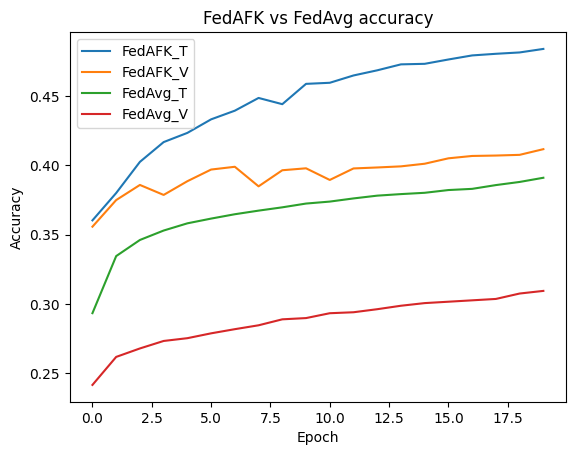

In [14]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history_["global_history"]["multiclassaccuracy"])
plt.plot(history_["global_history"]["val_multiclassaccuracy"])
plt.title("FedAFK vs FedAvg accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["FedAFK_T", "FedAFK_V", "FedAvg_T", "FedAvg_V"], loc="upper left")
plt.show()